In [1]:
# imports
from dataPreProcessing import get_tagged_sentences,\
    get_labels_words,\
    addCharInformatioin, create_word_index,createMatrices,\
    padding, defineBatches, fetch_minibatch
from keras_contrib.layers import CRF
import numpy as np
from keras.models import Model
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,MaxPooling1D,Flatten,concatenate
from keras.utils import Progbar
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import RandomUniform
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# load and pre process the data
train_sentences = get_tagged_sentences('data')
train_sentences = addCharInformatioin(train_sentences)
labels, words = get_labels_words(train_sentences)


# create a dict to map the classes to numbers
label_map = {}
for label in labels:
    label_map[label] = len(label_map)


# Hard coded charecter lookup
char_map = {"PADDING":0, "UNKNOWN":1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|":
    char_map[c] = len(char_map)


# create a word to index map
word_map = create_word_index('data')
word_map['UNKNOWN_TOKEN'] = len(word_map)
word_map['PADDING_TOKEN'] = len(word_map)

# get the training set ready
train_set = padding(createMatrices(train_sentences,word_map,label_map, char_map))

# define batches
train_batches,train_batch_indices = defineBatches(train_set)



In [4]:
# main model

# word embedding
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=len(word_map), output_dim=100)(words_input)


# charecter embedding
character_input=Input(shape=(None,52,),name='char_input')
embed_char_out=TimeDistributed(Embedding(len(char_map),120,embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout= Dropout(0.3)(embed_char_out)
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(52))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.3)(char)

# main model
output = concatenate([words, char])
output = Bidirectional(LSTM(10, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)
output = TimeDistributed(Dense(len(label_map), activation='softmax'))(output)
    
model = Model(inputs=[words_input,character_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam')
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, None, 52)     0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, None, 52, 120 11400       char_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 52, 120 0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 52, 30) 10830       dropout_1[0][0]                  
__________________________________________________________________________________________________
time_distr

In [5]:
# load dev set
dev_sentences = get_tagged_sentences('dev')
dev_sentences = addCharInformatioin(dev_sentences)
dev_set = padding(createMatrices(dev_sentences,word_map,  label_map, char_map))

In [6]:
def get_predictions(model):
    pred_labels = []
    orig_labels = []
    for i,data in enumerate(dev_set):
            tokens,char, labels = data
            tokens = np.asarray([tokens])
            char = np.asarray([char])
            pred = model.predict([tokens, char])[0]
            pred = pred.argmax(axis=-1)
            pred_labels.append(pred)
            orig_labels.append(labels)
    return(get_accuracy(pred_labels, orig_labels))

def get_accuracy(pred_labels, orig_labels):
    # calculate accuray of dev set
    label_pred = []
    for sentence in pred_labels:
        for word in sentence:
            label_pred.append(word)

    label_correct = []
    for sentence in orig_labels:
        for word in sentence:
            label_correct.append(word)

    corerct = 0
    for i in range(len(label_correct)):
        if label_pred[i] == label_correct[i]:
            corerct +=1
    return (corerct/len(label_correct))

In [7]:
# train model
epochs =50
accs = []
for epoch in range(epochs):
    print("Epoch %d/%d"%(epoch,epochs))
    a = Progbar(len(train_batch_indices))
    for i,batch in enumerate(fetch_minibatch(train_batches,train_batch_indices)):
        labels, tokens, char = batch
        model.train_on_batch([tokens, char], labels)
        a.update(i)
    acc = get_predictions(model)
    print (acc)
    accs.append(acc)

Epoch 0/50
62/63 [============================>.] - ETA: 0s0.634574841883345
Epoch 1/50
62/63 [============================>.] - ETA: 0s0.6943078004216444
Epoch 2/50
62/63 [============================>.] - ETA: 0s0.7748887327242914
Epoch 3/50
62/63 [============================>.] - ETA: 0s0.8074490513000703
Epoch 4/50
62/63 [============================>.] - ETA: 0s0.813305223705786
Epoch 5/50
62/63 [============================>.] - ETA: 0s0.8189271492152729
Epoch 6/50
62/63 [============================>.] - ETA: 0s0.8212696181775592
Epoch 7/50
62/63 [============================>.] - ETA: 0s0.8280627781681893
Epoch 8/50
62/63 [============================>.] - ETA: 0s0.8280627781681893
Epoch 9/50
62/63 [============================>.] - ETA: 0s0.8343874443663621
Epoch 10/50
62/63 [============================>.] - ETA: 0s0.8329819629889904
Epoch 11/50
62/63 [============================>.] - ETA: 0s0.8437573202155071
Epoch 12/50
62/63 [============================>.] - ETA: 0s0.83

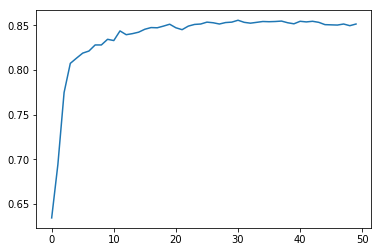

In [8]:
X= [i for i in range(50)]
plt.plot(X, accs)
plt.show()

In [12]:
model.save('ner_events.h5')

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)